# Multiresolution Hash Encoding

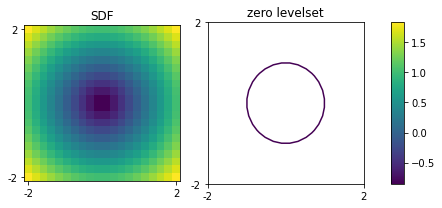

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
import functools as ft
import optax
import treex as tx
from sdf_jax import plot2d, discretize2d
from sdf_jax import SimpleNeuralSDF, train_step


def sdf_sphere(x):
    return jnp.linalg.norm(x) - 1

plot2d(sdf_sphere, ngrid=20)

In [2]:
def hash_vertex(v, size):
    primes = [1, 2654435761, 805459861]
    h = 0
    for i in range(v.ndim):
        h ^= v[i] * primes[i]
    return h % size

def trilinear_interpolation(values, weights):
    # https://en.wikipedia.org/wiki/Trilinear_interpolation
    c00 = values[int('000',2)]*(1.0-weights[0]) + values[int('100',2)]*weights[0]
    c01 = values[int('001',2)]*(1.0-weights[0]) + values[int('101',2)]*weights[0]
    c10 = values[int('010',2)]*(1.0-weights[0]) + values[int('110',2)]*weights[0]
    c11 = values[int('011',2)]*(1.0-weights[0]) + values[int('111',2)]*weights[0]
    c0 = c00*(1.0-weights[1]) + c10*weights[1]
    c1 = c01*(1.0-weights[1]) + c11*weights[1]
    c = c0*(1.0-weights[2]) + c1*weights[2]
    return c

@jax.jit
def encode(x, theta, nmin=16, nmax=512, levels=16, hashmap_size_log2=14):
    t = 1 << hashmap_size_log2
    box = np.array([[i,j,k] for i in (0,1) for j in (0,1) for k in (0,1)])
    b = np.exp((np.log(nmax) - np.log(nmin)) / (levels - 1))
    y = []
    for l in range(levels):
        nl = jnp.floor(nmin * b**l)
        xl = x * nl
        xl_ = jnp.floor(xl).astype(jnp.int32)

        # hash
        indices = jax.vmap(lambda v: hash_vertex(xl_ + v, t))(box)

        # lookup
        tl = theta[l][indices]

        # interpolate
        wl = (xl - xl_)
        xi = trilinear_interpolation(tl, wl)

        # concatenate
        y += [xi]
    return jnp.vstack(y)

In [3]:
x = jnp.array([1.1, 2.2, 1.3])
key = jrandom.PRNGKey(1234)
key, theta_key = jrandom.split(key, 2)
theta = jrandom.uniform(theta_key, (16, 2**14, 2), minval=-0.0001, maxval=0.0001)

In [4]:
%timeit encode(x, theta).block_until_ready()

25.9 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
